In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.insert(0,"../")

In [ ]:
from torch.utils.data import DataLoader
import torch

In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from core.model.model import MoCo_scene_and_view as MoCo
from core.dataloader import CLEVR_train, collate_boxes, CLEVR_train_onlyquery, collate_boxes_onlyquery
from core.utils import compute_features

In [ ]:
# kmeans_train_dataset = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5v.txt')
# kmeans_train_loader = DataLoader(kmeans_train_dataset, batch_size=16, shuffle=False, collate_fn=collate_boxes_onlyquery)

query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt', hyp_N=2)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

Initialised..... 10  files...


In [ ]:
model = MoCo(mode="spatial", scene_r=20, view_r=65)
model = model.cuda()

freezing feature extractor scene graph
freezing feature extractor encoder
freezing feature extractor scene graph
freezing feature extractor encoder


In [ ]:
PATH = "/home/mprabhud/saksham/non-metric_3d_representation/tb_logs/two_obj_spatial_with_scene_and_view_loss_exp9/checkpoint_99.pth.tar"
model.load_state_dict(torch.load(PATH)['state_dict'])

<All keys matched successfully>

In [ ]:
class DoublePool_O():
    def __init__(self, pool_size, isnode=True):
        self.pool_size = pool_size
        self.isnode = isnode
        random.seed(125)
        if self.pool_size > 0:
            self.num = 0
            self.embeds = []
            #self.scene_nums = []
            self.images = []
            self.sub_box = []
            self.scene_num = []
            self.view_num = []
            if not self.isnode:
                self.obj_box = []

    def fetch(self):
        if self.isnode:
            return self.embeds, self.images, self.sub_box #, self.classes,None, self.visual2D
        return self.embeds, self.images, self.sub_box, self.obj_box
            
    def is_full(self):
        full = self.num==self.pool_size
        # print 'num = %d; full = %s' % (self.num, full)
        return full
            
    def update(self, embeds, images, sub_boxs=None, obj_boxs=None, scene_num=None, view_num=None):
        # embeds is B x ... x C
        # images is B x ... x 3
        assert embeds.shape[0]==images.shape[0]
        assert embeds.shape[0]==sub_boxs.shape[0]
        

        if self.isnode:
            for embed, image, sub_box in zip(embeds, images, sub_boxs):
                if self.num < self.pool_size:
                    # the pool is not full, so let's add this in
                    self.num = self.num + 1
                else:
                    # the pool is full
                    # pop from the front
                    self.embeds.pop(0)
                    self.images.pop(0)
             
                    self.sub_box.pop(0)
                    #self.visual2D.pop(0)
                # add to the back
                self.embeds.append(embed)
                self.images.append(image)
           
                self.sub_box.append(sub_box)
        else:
            assert sub_boxs.shape[0]==obj_boxs.shape[0]
            
            for embed, image, sub_box, obj_box in zip(embeds, images, sub_boxs, obj_boxs):
                if self.num < self.pool_size:
                    # the pool is not full, so let's add this in
                    self.num = self.num + 1
                else:
                    # the pool is full
                    # pop from the front
                    self.embeds.pop(0)
                    self.images.pop(0)
               
                    self.sub_box.pop(0)
                    self.obj_box.pop(0)
                    
                    self.scene_num.pop(0)
                    self.view_num.pop(0)
                    
                # add to the back
                self.embeds.append(embed)
                self.images.append(image)
        
                self.sub_box.append(sub_box)
                self.obj_box.append(obj_box)
                
                self.scene_num.append(scene_num)
                self.view_num.append(view_num)

In [ ]:
from attrdict import AttrDict

args = AttrDict({
    'mode':"spatial",
    'hyp_N':2
})

In [ ]:
from tqdm import tqdm

def store_to_pool_e(pool_e, feed_dict_q, metadata, model, args, scene_num, view_num):
    
#     st()
    #print('Storing to pool...')    
    
    model.eval()
    with torch.no_grad():
        feat_q = model(feed_dict_q, None, metadata, is_eval=True)
        
        dim1 = feat_q.shape[0]
        img_q = torch.zeros([dim1, 3, 256, 256])        
        
        if args.mode=='node':
            cnt = 0
            
            for b in range(feed_dict_q["objects_boxes"].shape[0]//args.hyp_N):
                for s in range(args.hyp_N):
                    img_q[cnt] = feed_dict_q["images"][b]
                    cnt += 1
                    
            pool_e.update(feat_q, img_q, feed_dict_q["objects_boxes"], None)
            
        else:
            dim1 = feat_q.shape[0]
            subj_q = torch.zeros([dim1, 4])
            obj_q = torch.zeros([dim1, 4])
            
            cnt = 0
            for b in range(feed_dict_q["objects_boxes"].shape[0]//args.hyp_N):
                for s in range(args.hyp_N):
                    for o in range(args.hyp_N):
                        img_q[cnt] = feed_dict_q["images"][b]
                        cnt += 1
            
            cnt = 0
            for b in range(feed_dict_q["objects_boxes"].shape[0]//args.hyp_N):
                for s in range(args.hyp_N):
                    for o in range(args.hyp_N):
                        start_idx = b*args.hyp_N
                        subj_q[cnt] = feed_dict_q["objects_boxes"][start_idx + s]
                        obj_q[cnt] = feed_dict_q["objects_boxes"][start_idx + o]
                        cnt += 1
                    
            pool_e.update(feat_q, img_q, subj_q, obj_q, scene_num, view_num)           
                
    return

def store_to_pool_g(pool_g, feed_dict_k, metadata, model, args, scene_num, view_num):
    
    
    model.eval()
    with torch.no_grad():
        feat_k = model(feed_dict_k, None, metadata, is_viewpoint_eval=True)
        
        dim1 = feat_k.shape[0]
        img_k = torch.zeros([dim1, 3, 256, 256])        
        
        if args.mode=='node':
            print("")
            cnt = 0
            
            for b in range(feed_dict_k["objects_boxes"].shape[0]//args.hyp_N):
                for s in range(args.hyp_N):
                    img_k[cnt] = feed_dict_k["images"][b]
                    cnt += 1
                    
            pool_g.update(feat_k, img_k, feed_dict_k["objects_boxes"], None)
            
        else:
            dim1 = feat_k.shape[0]
            subj_k= torch.zeros([dim1, 4])
            obj_k = torch.zeros([dim1, 4])
            
            cnt = 0
            for b in range(feed_dict_k["objects_boxes"].shape[0]//args.hyp_N):
                for s in range(args.hyp_N):
                    for o in range(args.hyp_N):
                        img_k[cnt] = feed_dict_k["images"][b]
                        cnt += 1
            
            cnt = 0
            for b in range(feed_dict_k["objects_boxes"].shape[0]//args.hyp_N):
                for s in range(args.hyp_N):
                    for o in range(args.hyp_N):
                        start_idx = b*args.hyp_N
                        subj_k[cnt] = feed_dict_k["objects_boxes"][start_idx + s]
                        obj_k[cnt] = feed_dict_k["objects_boxes"][start_idx + o]
                        cnt += 1
                    
            pool_g.update(feat_k, img_k, subj_k, obj_k, scene_num, view_num)           
                
    return

In [ ]:
from core.dataloader import sample_same_scene_negs

In [ ]:
k_data = []

In [ ]:
pool_size = 63
pool_e_ = DoublePool_O(pool_size, isnode=False)
pool_g_ = DoublePool_O(2000, isnode=False)
pool_f_= DoublePool_O(pool_size, isnode=False)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

for i, (feed_dict_q_, feed_dict_k_, metadata_) in enumerate((query_train_loader)):
    
    q_idx = metadata_["query_image_index"].item()
    k_idx = metadata_["key_image_index"].item()
    scene_num = metadata_["scene_number"].item()
    
    store_to_pool_e(pool_e_, feed_dict_q_, metadata_, model,args, scene_num, q_idx)
    store_to_pool_e(pool_f_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    store_to_pool_g(pool_g_, feed_dict_k_, metadata_, model,args, scene_num, k_idx)
    
    feed_dict_n_lists = sample_same_scene_negs(feed_dict_q_, feed_dict_k_, metadata_, args.hyp_N, 16)[0]
    
    for feed_dict_n,view_idx in feed_dict_n_lists:
        store_to_pool_e(pool_g_, feed_dict_n, metadata_, model, args, scene_num, view_idx.item())

        
print(pool_e_.num)
print(pool_g_.num)

../core/utils_data.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


40
684


In [ ]:
# from tqdm import tqdm

# def store_to_pool_g(pool_g, feed_dict_k, metadata, model, args):
    
    
#     model.eval()
#     with torch.no_grad():
#         feat_k = model(feed_dict_k, None, metadata, is_viewpoint_eval=True)
        
#         dim1 = feat_k.shape[0]
#         img_k = torch.zeros([dim1, 3, 256, 256])        
        
#         if args.mode=='node':
#             print("")
#             cnt = 0
            
#             for b in range(feed_dict_k["objects_boxes"].shape[0]//args.hyp_N):
#                 for s in range(args.hyp_N):
#                     img_k[cnt] = feed_dict_k["images"][b]
#                     cnt += 1
                    
#             pool_g.update(feat_k, img_k, feed_dict_k["objects_boxes"], None)
            
#         else:
#             dim1 = feat_k.shape[0]
#             subj_k= torch.zeros([dim1, 4])
#             obj_k = torch.zeros([dim1, 4])
            
#             cnt = 0
#             for b in range(feed_dict_k["objects_boxes"].shape[0]//args.hyp_N):
#                 for s in range(args.hyp_N):
#                     for o in range(args.hyp_N):
#                         img_k[cnt] = feed_dict_k["images"][b]
#                         cnt += 1
            
#             cnt = 0
#             for b in range(feed_dict_k["objects_boxes"].shape[0]//args.hyp_N):
#                 for s in range(args.hyp_N):
#                     for o in range(args.hyp_N):
#                         start_idx = b*args.hyp_N
#                         subj_k[cnt] = feed_dict_k["objects_boxes"][start_idx + s]
#                         obj_k[cnt] = feed_dict_k["objects_boxes"][start_idx + o]
#                         cnt += 1
                    
#             pool_g.update(feat_k, img_k, subj_k, obj_k)           
                
#     return

In [ ]:
hashes = []

In [ ]:
# hash_collisions = 0

# pool_size = 2000
# pool_g = DoublePool_O(pool_size, isnode=False)

# train_iter = iter(query_train_loader)

# for i in range(100):
#         try:
#             feed_dict_q_, feed_dict_k_, metadata_ = next(train_iter)
#         except StopIteration:
#             # restart the generator if the previous generator is exhausted.
#             query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5v.txt', hyp_N=2)
#             query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)            
            
#             train_iter = iter(query_train_loader)
#             feed_dict_q_, feed_dict_k_, metadata_ = next(train_iter)
        
# #         pose = metadata_["rel_viewpoint"][0][0].cpu().tolist()
# #         print(pose)
        
        
# #         if hash(frozenset(pose)) in hashes:
# #             hash_collisions +=1
# #             continue
        
# #         hashes.append(hash(frozenset(pose)))
#         store_to_pool_g(pool_g, feed_dict_k_, metadata_, model,args)

In [ ]:
import cv2

def draw_bounding_box(image, sub_box, obj_box):
        
    x1,y1,x2,y2 = sub_box
    x1 = int(x1.item()); x2 = int(x2.item()); y1 = int(y1.item()); y2 = int(y2.item())
    img1 = cv2.rectangle(image.copy(),(x1,y1),(x2,y2),(0,255,0),2)
    
    if not obj_box==None:
        x1,y1,x2,y2 = obj_box
        x1 = int(x1.item()); x2 = int(x2.item()); y1 = int(y1.item()); y2 = int(y2.item())
        img = cv2.rectangle(img1.copy(),(x1,y1),(x2,y2),(255,0,0),2)
        return img
    
    return img
        

def plot_query_retrieval(imgs_retrieval, outFile, args):
#     st()
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(20, 12))
    for idx in range(n_retrieval):
        for im in range(0, 12):
            ax = fig.add_subplot(n_retrieval, 12, 12*idx+im+1,xticks=[], yticks=[])
            if args.mode=='node':
                im_to_plot = draw_bounding_box(imgs_retrieval[idx][0][im], imgs_retrieval[idx][1][im], None)
            else:
                im_to_plot = draw_bounding_box(imgs_retrieval[idx][0][im], imgs_retrieval[idx][1][im], imgs_retrieval[idx][2][im])
            if im>1:
                ax.set_title('S:{}, V:{}'.format(imgs_retrieval[idx][-2][im], imgs_retrieval[idx][-1][im]))
            else:
#                 ax.set_title('Top_'+str(im))
                ax.set_title('S:{}, V:{}'.format(imgs_retrieval[idx][-2][im], imgs_retrieval[idx][-1][im]))
            ax.imshow(im_to_plot)
    plt.show()
    plt.close(fig)
    return fig

In [ ]:
from sklearn.neighbors import NearestNeighbors
def random_retrieve_topk(args, pool_e=None, pool_g=None, imgs_to_view=3):
    
#     st()
    
    print("==> Fitting k-nearest-neighbour model on pool g...")
    knn = NearestNeighbors(n_neighbors=10, metric="cosine")
    knn.fit(torch.stack(pool_g.embeds).cpu())
    
    # select imgs_to_view images from pool q randomly
    query_indices_to_use = random.sample(range(0, pool_e.num), imgs_to_view)
    
    
    figures_gen = []
    print(query_indices_to_use)

    # Perform image retrieval on test images
    print("==> Performing image retrieval on test images...")
    for i, index in enumerate(query_indices_to_use):
        temp = []
        distances, indices = knn.kneighbors(torch.reshape(pool_e.embeds[index], (1,-1)).cpu()) # find k nearest train neighbours

        img_query = pool_e.images[index].permute(1,2,0).cpu().numpy() # query image
        img_key = pool_f_.images[index].permute(1,2,0).cpu().numpy()
        temp.append(img_query)
        temp.append(img_key)
        
        imgs_retrieval = [pool_g.images[idx].permute(1,2,0).cpu().numpy() for idx in indices.flatten()]# retrieval images
        temp.extend(imgs_retrieval)
        
        imgs_sub_boxes = [pool_e.sub_box[index], pool_f_.sub_box[index]]
        imgs_sub_boxes.extend([pool_g.sub_box[idx] for idx in indices.flatten()])

        imgs_obj_boxes = None
        
        if args.mode=='spatial':
            imgs_obj_boxes = [pool_e.obj_box[index], pool_f_.obj_box[index]]
            imgs_obj_boxes.extend([pool_g.obj_box[idx] for idx in indices.flatten()])

            
        scene_nums=[pool_e.scene_num[index], pool_f_.scene_num[index]]
        scene_nums.extend([pool_g.scene_num[idx] for idx in indices.flatten()])
        
        view_nums = [pool_e.view_num[index], pool_f_.view_num[index]]
        view_nums.extend([pool_g.view_num[idx] for idx in indices.flatten()])

        figures_gen.append([temp, imgs_sub_boxes, imgs_obj_boxes, distances[0],scene_nums, view_nums])
        
    fig = plot_query_retrieval(figures_gen, None, args)

    return figures_gen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


==> Fitting k-nearest-neighbour model on pool g...
[2, 29, 15, 5, 19, 30, 11]
==> Performing image retrieval on test images...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

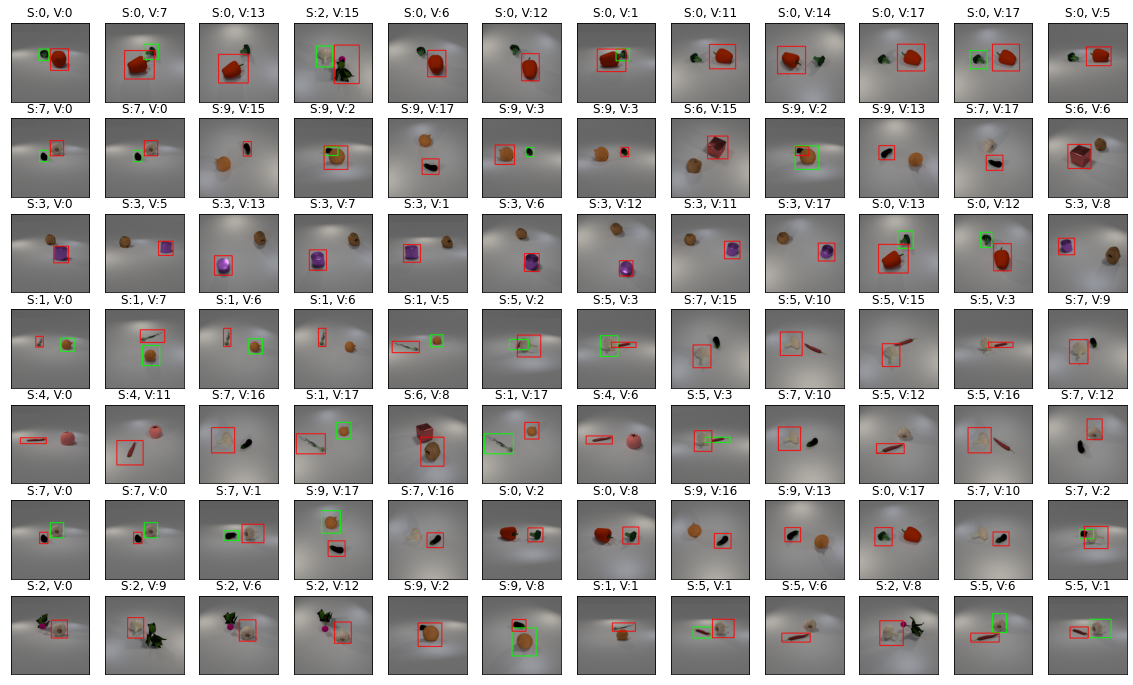

In [ ]:
f = random_retrieve_topk(args, pool_e_, pool_g_, imgs_to_view=7)

In [ ]:
p.grad